# Bellman Equation Collocation Method

In [1]:
using BasisMatrices
using QuantEcon
using Optim
using Plots

For discrete time dynamic programs
with 1-dimenstional continuous states and actions:

In [2]:
struct DPModel{N,K,TM<:AbstractMatrix,TL<:Factorization}
    f::Function
    g::Function
    discount::Float64
    shocks::Array{Float64,K}
    weights::Vector{Float64}
    grid_size::NTuple{N,Int}
    grid_length::Int
    grid_min::NTuple{N,Float64}
    grid_max::NTuple{N,Float64}
    basis::Basis{N}
    S::Array{Float64,N}
    Phi::TM
    Phi_lu::TL
    x_lb::Function
    x_ub::Function
end

In [3]:
function DPModel(f::Function, g::Function, discount::Float64, 
                 shocks::Array{Float64}, weights::Vector{Float64},
                 basis::Basis,
                 x_lb::Function, x_ub::Function)
    S, _ = nodes(basis)
    grid_size = size(basis)
    grid_length = length(basis)
    grid_min, grid_max = min(basis), max(basis)
    Phi = BasisMatrix(basis, Expanded(), S).vals[1]
    Phi_lu = lufact(Phi)
    dp = DPModel(f, g, discount, shocks, weights,
                 grid_size, grid_length, grid_min, grid_max, basis, S, Phi, Phi_lu, x_lb, x_ub)
    return dp
end

DPModel

In [4]:
function _vmax(dp::DPModel, s, C; method::Optim.Optimizer=Brent())
    function objective(x)
        out = 0.
        t = Base.tail(indices(dp.shocks))
        for (i, w) in enumerate(dp.weights)
            e = dp.shocks[(i, t...)...]
            out += w * funeval(C, dp.basis, dp.g(s, x, e))
        end
        out *= dp.discount
        out += dp.f(s, x)
        out *= -1
        return out
    end
    res = optimize(objective, x_lb(s), x_ub(s), method=method)
    v = -res.minimum::Float64
    x = res.minimizer::Float64
    return v, x
end

_vmax (generic function with 1 method)

In [5]:
function vmax!(dp::DPModel, ss::AbstractArray{Float64}, C::Vector{Float64},
               Tv::Vector{Float64})
    n = size(ss, 1)
    t = Base.tail(indices(ss))
    for i in 1:n
        Tv[i], _ = _vmax(dp, ss[(i, t...)...], C)
    end
    return Tv
end

function vmax!(dp::DPModel, ss::AbstractArray{Float64}, C::Vector{Float64},
               Tv::Vector{Float64}, X::Vector{Float64})
    n = size(ss, 1)
    t = Base.tail(indices(ss))
    for i in 1:n
        Tv[i], X[i] = _vmax(dp, ss[(i, t...)...], C)
    end 
    return Tv, X
end

function vmax(dp::DPModel, ss::AbstractArray{Float64}, C::Vector{Float64})
    n = size(ss, 1)
    Tv, X = Array{Float64}(n), Array{Float64}(n)
    vmax!(dp, ss, C, Tv, X)
end

vmax (generic function with 1 method)

In [6]:
function bellman_operator!(dp::DPModel, C::Vector{Float64},
                           Tv::Vector{Float64})
    Tv = vmax!(dp, dp.S, C, Tv)
    A_ldiv_B!(C, dp.Phi_lu, Tv)
    return C
end

bellman_operator! (generic function with 1 method)

In [7]:
function compute_greedy!(dp::DPModel, ss::AbstractArray{Float64},
                         C::Vector{Float64}, X::Vector{Float64})
    n = size(ss, 1)
    t = Base.tail(indices(ss))
    for i in 1:n
        _, X[i] = _vmax(dp, ss[(i, t...)...], C)
    end
    return X
end

compute_greedy!(dp::DPModel, C::Vector{Float64}, X::Vector{Float64}) =
    compute_greedy!(dp, dp.S, C, X)

compute_greedy! (generic function with 2 methods)

In [8]:
function evaluate_policy!(dp::DPModel, X::Vector{Float64}, C::Vector{Float64})
    n = size(dp.S, 1)
    ts = Base.tail(indices(dp.S))
    te = Base.tail(indices(dp.shocks))
    A = copy(dp.Phi)
    for i in 1:n
        for (j, w) in enumerate(dp.weights)
            s = dp.S[(i, ts...)...]
            e = dp.shocks[(j, te...)...]
            A[i, :] -= dp.discount * w * vec(evalbase(dp.basis.params[1], dp.g(s, X[i], e)))
        end
    end
    A_lu = lufact(A)
    b = Array{Float64}(n)
    for i in 1:n
        s = dp.S[(i, ts...)...]
        b[i] = f(s, X[i])
    end
    A_ldiv_B!(C, A_lu, b)
    return C
end

evaluate_policy! (generic function with 1 method)

In [9]:
function operator_iteration!{TC}(T::Function, C::TC;
                                 tol::Float64=1e-4, max_iter::Int=100,
                                 verbose::Int=2, print_skip::Int=50)
    i = 0
    err = tol + 1
    C_old = similar(C)
    while i < max_iter && err > tol
        copy!(C_old, C)
        C = T(C)::TC
        err = maximum(abs, C - C_old)
        i += 1
        
        (i >= max_iter || err <= tol) && break
        
        if (verbose == 2) && (i % print_skip == 0)
            println("Compute iterate $i with error $err")
        end
    end
    
    if verbose == 2
        println("Compute iterate $i with error $err")
    end
    
    if verbose >= 1
        if err > tol
            warn("max_iter attained")
        elseif verbose == 2
            println("Converged in $i steps")
        end
    end
    
    return C
end

operator_iteration! (generic function with 1 method)

## Optimal Economic Growth

In [10]:
n = 10
s_min, s_max = 5, 10;

In [11]:
basis = Basis(ChebParams(n, s_min, s_max))

1 dimensional Basis on the hypercube formed by (5.0,) × (10.0,).
Basis families are Cheb


In [12]:
alpha = 0.2
bet = 0.5
gamm = 0.9
sigma = 0.1
discount = 0.9;

In [13]:
x_star = ((discount * bet) / (1 - discount * gamm))^(1 / (1 - bet))
s_star = gamm * x_star + x_star^bet
s_star, x_star

(7.416897506925212, 5.6094182825484795)

In [14]:
f(s, x) = (s - x)^(1 - alpha) / (1 - alpha)
g(s, x, e) = gamm * x + e * x^bet;

In [15]:
n_shocks = 3
shocks, weights = qnwlogn(n_shocks, -sigma^2/2, sigma^2)  # See Errata

([0.836771, 0.995012, 1.18318], [0.166667, 0.666667, 0.166667])

We follow [mfdp07.m](https://github.com/PaulFackler/CompEcon/blob/56e740e9e2e380318e11f79ce8aca92533a964d6/CEdemos/mfdp07.m#L6)
in CompEcon:

In [16]:
x_lb(s) = 0
x_ub(s) = 0.99 * s;

In [17]:
dp = DPModel(f, g, discount, shocks, weights, basis, x_lb, x_ub)

DPModel{1,1,Array{Float64,2},Base.LinAlg.LU{Float64,Array{Float64,2}}}(f, g, 0.9, [0.836771, 0.995012, 1.18318], [0.166667, 0.666667, 0.166667], (10,), 10, (5.0,), (10.0,), 1 dimensional Basis on the hypercube formed by (5.0,) × (10.0,).
Basis families are Cheb
, [5.03078, 5.27248, 5.73223, 6.36502, 7.10891, 7.89109, 8.63498, 9.26777, 9.72752, 9.96922], [1.0 -0.987688 … 0.309017 -0.156434; 1.0 -0.891007 … -0.809017 0.45399; … ; 1.0 0.891007 … -0.809017 -0.45399; 1.0 0.987688 … 0.309017 0.156434], Base.LinAlg.LU{Float64,Array{Float64,2}} with factors L and U:
[1.0 0.0 … 0.0 0.0; 1.0 1.0 … 0.0 0.0; … ; 1.0 0.0489435 … 1.0 0.0; 1.0 0.579192 … -0.45965 1.0]
[1.0 -0.987688 … 0.309017 -0.156434; 0.0 1.97538 … -1.4877e-14 0.312869; … ; 0.0 0.0 … -5.25731 1.64485; 0.0 0.0 … 0.0 5.06233], x_lb, x_ub)

### Value iteration

In [18]:
tol = sqrt(eps())
max_iter = 250
Tv = Array{Float64}(dp.grid_length)  # Temporary array
bellman_operator!(C) = bellman_operator!(dp, C, Tv)
C = zeros(dp.grid_length)
C = operator_iteration!(bellman_operator!, C; tol=tol, max_iter=max_iter);

Compute iterate 50 with error 0.008569366466243622
Compute iterate 100 with error 4.4164588459238985e-5
Compute iterate 150 with error 2.2761436468954344e-7
Compute iterate 176 with error 1.4706344586556952e-8
Converged in 176 steps


In [19]:
s_min, s_max = dp.grid_min[1], dp.grid_max[1]
grid_length = 500
ss = linspace(s_min, s_max, grid_length)
V, X = vmax(dp, ss, C)
resid = V - funeval(C, dp.basis, ss);


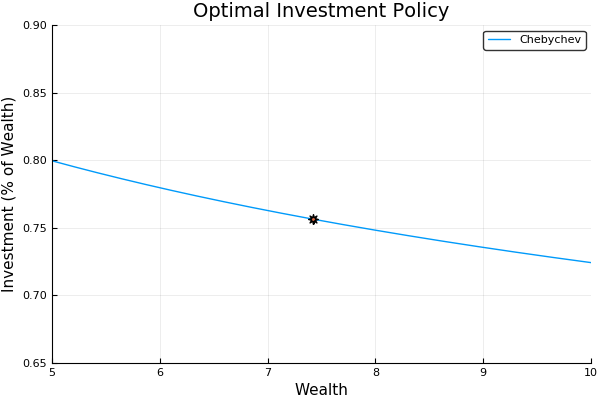

In [20]:
title = "Optimal Investment Policy"
xlabel = "Wealth"
ylabel = "Investment (% of Wealth)"
plot(ss, X./ss, xlims=(s_min, s_max), ylims=(0.65, 0.9),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Chebychev")
plot!([s_star], [x_star/s_star], m=(7,:star8), label="")


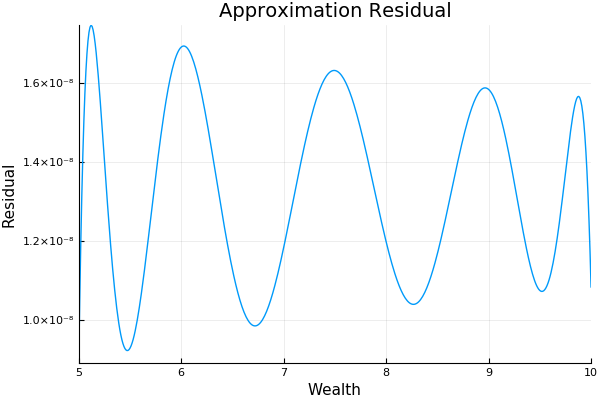

In [21]:
title = "Approximation Residual"
ylabel = "Residual"
plot(ss, resid, xlims=(s_min, s_max), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

### Policy iteration

In [22]:
function policy_iteration_operator!(dp::DPModel, C::Vector{Float64}, X::Vector{Float64})
    compute_greedy!(dp, C, X)
    evaluate_policy!(dp, X, C)
    return C
end

policy_iteration_operator! (generic function with 1 method)

In [23]:
tol = sqrt(eps())
max_iter = 250
X = Array{Float64}(dp.grid_length)  # Temporary array
policy_iteration_operator!(C) = policy_iteration_operator!(dp, C, X)
C = zeros(dp.grid_length)
C = operator_iteration!(policy_iteration_operator!, C; tol=tol, max_iter=max_iter);

Compute iterate 6 with error 5.773159728050814e-15
Converged in 6 steps


In [24]:
s_min, s_max = dp.grid_min[1], dp.grid_max[1]
grid_length = 500
ss = linspace(s_min, s_max, grid_length)
V, X = vmax(dp, ss, C)
resid = V - funeval(C, dp.basis, ss);


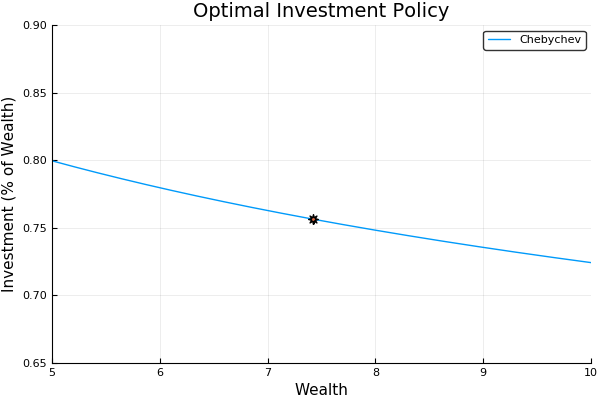

In [25]:
title = "Optimal Investment Policy"
xlabel = "Wealth"
ylabel = "Investment (% of Wealth)"
plot(ss, X./ss, xlims=(s_min, s_max), ylims=(0.65, 0.9),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Chebychev")
plot!([s_star], [x_star/s_star], m=(7,:star8), label="")


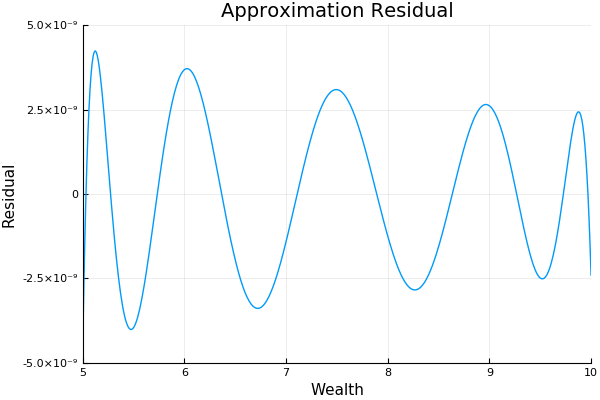

In [26]:
title = "Approximation Residual"
ylabel = "Residual"
plot(ss, resid, xlims=(s_min, s_max), ylims=(-5e-9, 5e-9), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

## Nonrenewable Resource Management

In [27]:
k = 3
m = 101
breaks = m - (k-1)
s_min, s_max = 0, 10;

In [28]:
basis = Basis(SplineParams(breaks, s_min, s_max, 3))

1 dimensional Basis on the hypercube formed by (0.0,) × (10.0,).
Basis families are Spline


In [29]:
a = [10, 0.8]
b = [12, 1.0]
discount = 0.9;

We follow [mfdp09.m](https://github.com/PaulFackler/CompEcon/blob/56e740e9e2e380318e11f79ce8aca92533a964d6/CEdemos/mfdp09.m#L8)
in CompEcon, rather than the book, to reproduce the figures there:

In [30]:
p(x) = a[1] - a[2] * x / 2
c(s, x) = b[1] * x - b[2] * x * (2*s - x) / 2
f(s, x) = p(x) * x - c(s, x)
g(s, x, e) = s - x;

In [31]:
shocks, weights = [0.], [1.];

In [32]:
x_lb(s) = 0
x_ub(s) = s;

In [33]:
dp = DPModel(f, g, discount, shocks, weights, basis, x_lb, x_ub)

DPModel{1,1,SparseMatrixCSC{Float64,Int64},Base.SparseArrays.UMFPACK.UmfpackLU{Float64,Int64}}(f, g, 0.9, [0.0], [1.0], (101,), 101, (0.0,), (10.0,), 1 dimensional Basis on the hypercube formed by (0.0,) × (10.0,).
Basis families are Spline
, [0.0, 0.0340136, 0.102041, 0.204082, 0.306122, 0.408163, 0.510204, 0.612245, 0.714286, 0.816327  …  9.18367, 9.28571, 9.38776, 9.4898, 9.59184, 9.69388, 9.79592, 9.89796, 9.96599, 10.0], 
  [1  ,   1]  =  1.0
  [2  ,   1]  =  0.296296
  [1  ,   2]  =  0.0
  [2  ,   2]  =  0.564815
  [3  ,   2]  =  0.25
  [1  ,   3]  =  0.0
  [2  ,   3]  =  0.132716
  [3  ,   3]  =  0.583333
  [4  ,   3]  =  0.166667
  [1  ,   4]  =  0.0
  ⋮
  [98 ,  99]  =  0.166667
  [99 ,  99]  =  0.583333
  [100,  99]  =  0.132716
  [101,  99]  =  0.0
  [98 , 100]  =  1.64861e-40
  [99 , 100]  =  0.25
  [100, 100]  =  0.564815
  [101, 100]  =  0.0
  [99 , 101]  =  4.22045e-41
  [100, 101]  =  0.296296
  [101, 101]  =  1.0, UMFPACK LU Factorization of a (101, 101) sparse matrix


In [34]:
tol = sqrt(eps())
max_iter = 250
Tv = Array{Float64}(dp.grid_length)  # Temporary array
bellman_operator!(C) = bellman_operator!(dp, C, Tv)
C = zeros(dp.grid_length)
C = operator_iteration!(bellman_operator!, C; tol=tol, max_iter=max_iter);

Compute iterate 38 with error 1.4533888759160618e-8
Converged in 38 steps


In [35]:
s_min, s_max = dp.grid_min[1], dp.grid_max[1]
grid_length = 500
ss = linspace(s_min, s_max, grid_length)
V, X = vmax(dp, ss, C)
B1 = evalbase(basis.params[1], ss, 1)
shadow_prices = B1 * C
resid = V - funeval(C, dp.basis, ss);


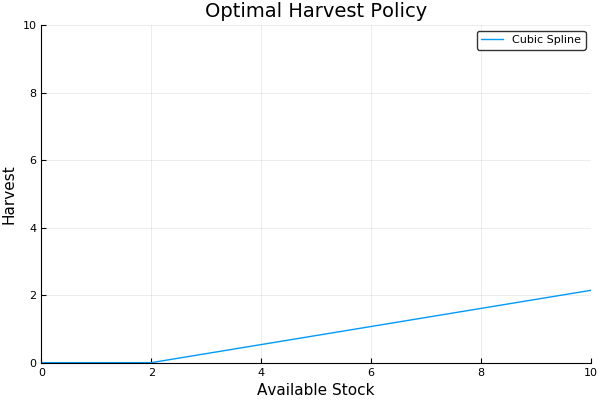

In [36]:
title = "Optimal Harvest Policy"
xlabel = "Available Stock"
ylabel = "Harvest"
plot(ss, X, xlims=(s_min, s_max), ylims=(0, 10),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")


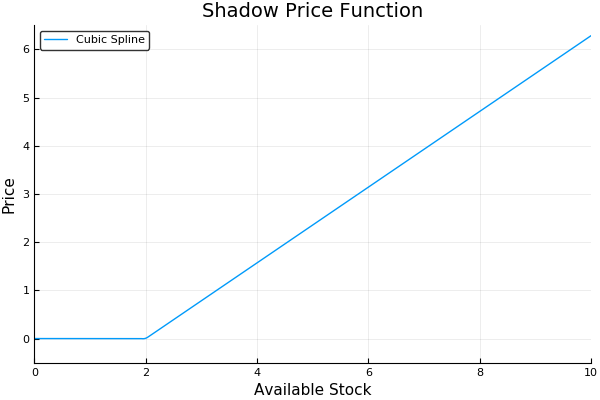

In [37]:
title = "Shadow Price Function"
ylabel = "Price"
plot(ss, shadow_prices, xlims=(s_min, s_max), ylims=(-0.5, 6.5),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")


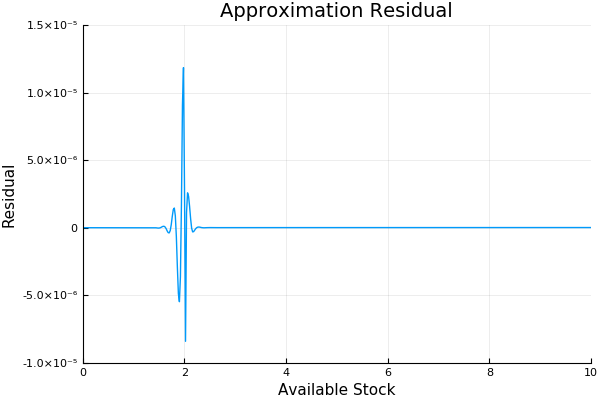

In [38]:
title = "Approximation Residual"
ylabel = "Residual"
plot(ss, resid, xlims=(s_min, s_max), ylims=(-1e-5, 1.5e-5), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

### Policy iteration

In [39]:
tol = sqrt(eps())
max_iter = 250
X = Array{Float64}(dp.grid_length)  # Temporary array
policy_iteration_operator!(C) = policy_iteration_operator!(dp, C, X)
C = zeros(dp.grid_length)
C = operator_iteration!(policy_iteration_operator!, C; tol=tol, max_iter=max_iter);

Compute iterate 6 with error 1.4210854715202004e-14
Converged in 6 steps


In [40]:
s_min, s_max = dp.grid_min[1], dp.grid_max[1]
grid_length = 500
ss = linspace(s_min, s_max, grid_length)
V, X = vmax(dp, ss, C)
B1 = evalbase(basis.params[1], ss, 1)
shadow_prices = B1 * C
resid = V - funeval(C, dp.basis, ss);


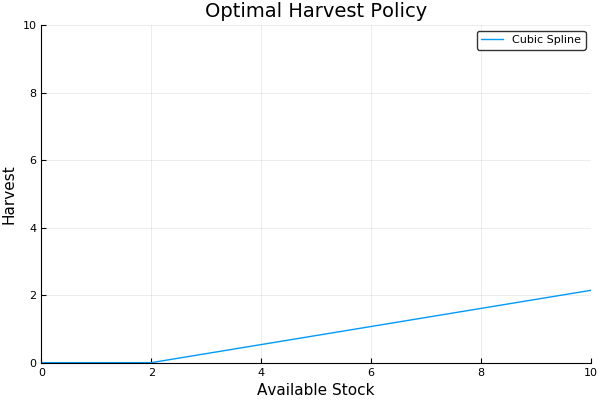

In [41]:
title = "Optimal Harvest Policy"
xlabel = "Available Stock"
ylabel = "Harvest"
plot(ss, X, xlims=(s_min, s_max), ylims=(0, 10),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")


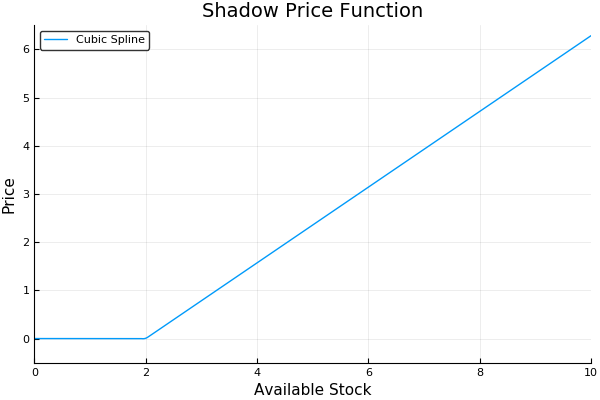

In [42]:
title = "Shadow Price Function"
ylabel = "Price"
plot(ss, shadow_prices, xlims=(s_min, s_max), ylims=(-0.5, 6.5),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")


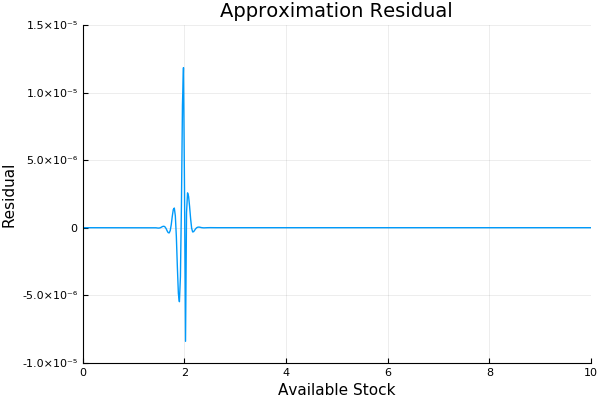

In [43]:
title = "Approximation Residual"
ylabel = "Residual"
plot(ss, resid, xlims=(s_min, s_max), ylims=(-1e-5, 1.5e-5), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")